# Aufenthaltsdauer in Zuständen aus Rohdaten

Offenes / Unklares: 
* Wie umgehen mit Fahrten die nicht zuhause enden? 
* Wie Aufenthaltsdauer des Endzustands berechnen? ->  *Ankuftszeit Endzustand bis erste Abfahrtszeit erste Fahrt?* 

### Zustände

* Zuhause -> 1
* Arbeit -> 2 
* Einkaufen -> 3 
* Freizeit -> 4
* Sonstiges -> 5

In [14]:
import pandas as pd
import numpy as np 
import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
df = pd.read_csv(r'C:\Users\thoma\Desktop\ev-modelling-repo\Data\NHTS_trips_processed.csv')

In [16]:
df["aufenthalt"] = 0

In [17]:
filt = df["ST_WOTAG"] < 6
df = df[filt]

In [18]:
df = df.sort_values(by=['ID', 'W_NR'])

In [19]:
df.reset_index(inplace=True)

In [20]:
df.tail(100)

,index,ID,ST_WOTAG,WHYFROM,zweck,W_NR,TRPTRANS,wegkm,wegmin_imp1,W_SZ,W_AZ,W_SZ_MIN,W_AZ_MIN,W_SZ_t,aufenthalt
632921,795074,407941791,2,1,4,1,6,7.078,15,930,945,570,585,38,0
632922,795075,407941791,2,4,3,2,6,8.932,45,1045,1130,645,690,43,0
632923,795076,407941791,2,3,3,3,6,4.263,25,1145,1210,705,730,47,0
632924,795077,407941791,2,3,3,4,6,4.371,25,1300,1325,780,805,52,0
632925,795078,407941791,2,3,3,5,6,4.371,15,1345,1400,825,840,55,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
633016,641872,4045582510,3,5,5,4,6,4.310,7,753,800,473,480,32,0
633017,641873,4045582510,3,5,3,5,6,3.421,17,803,820,483,500,32,0
633018,641874,4045582510,3,3,1,6,6,11.676,40,920,1000,560,600,37,0
633019,641875,4045582510,3,1,2,7,6,55.371,40,1520,1600,920,960,61,0


In [21]:
df.drop(columns=["index"], inplace=True)

In [22]:
person_grpd = df.groupby(['ID'], as_index=False)

In [23]:
def calc_aufenthalt(df):
    rows = df.shape[0]
    for i in range(rows):
        # letzter Trip der Person -> Aufenthalt = Zeit bis zum ersten Trip 
        if (i == rows-1) or (df.at[i+1, "ID"] != df.at[i, "ID"]):
            # Beispiel: Wenn Wegnummer = 3 liegt Index des ersten Wegs 2 Schritte zurück
            index_first_trip = i - (df.at[i, "W_NR"] - 1) 
            start_first_trip = df.at[index_first_trip, "W_SZ_MIN"]
            end_trip = df.at[i,"W_AZ_MIN"]
            # Gesamtaufenthalt = 
            # Rest des Tages + Zeit bis zum ersten Trip
            if end_trip > start_first_trip:           
                df.at[i, "aufenthalt"] = 1440 - end_trip + start_first_trip
            # Wenn letzte Fahrt nach 24:00
            elif end_trip < start_first_trip:
                df.at[i, "aufenthalt"] = start_first_trip - end_trip
        else:
            end_trip = df.at[i, "W_AZ_MIN"]
            start_next_trip = df.at[i+1, "W_SZ_MIN"]
            aufenthalt = start_next_trip - end_trip
            # wenn Aufenthalt < 0 ist nächster Trip nach 24:00 
            if aufenthalt < 0:
                aufenthalt = (1440 - end_trip) + start_next_trip
            df.at[i, "aufenthalt"] = aufenthalt
        
    

In [24]:
calc_aufenthalt(df)

In [25]:
filt = df["zweck"] == 1
aufenthalt_zuhause = df[filt]["aufenthalt"]
filt = df["zweck"] == 2
aufenthalt_arbeit = df[filt]["aufenthalt"]
filt = df["zweck"] == 3
aufenthalt_einkaufen = df[filt]["aufenthalt"]
filt = df["zweck"] == 4
aufenthalt_freizeit = df[filt]["aufenthalt"]
filt = df["zweck"] == 5
aufenthalt_sonstiges = df[filt]["aufenthalt"]

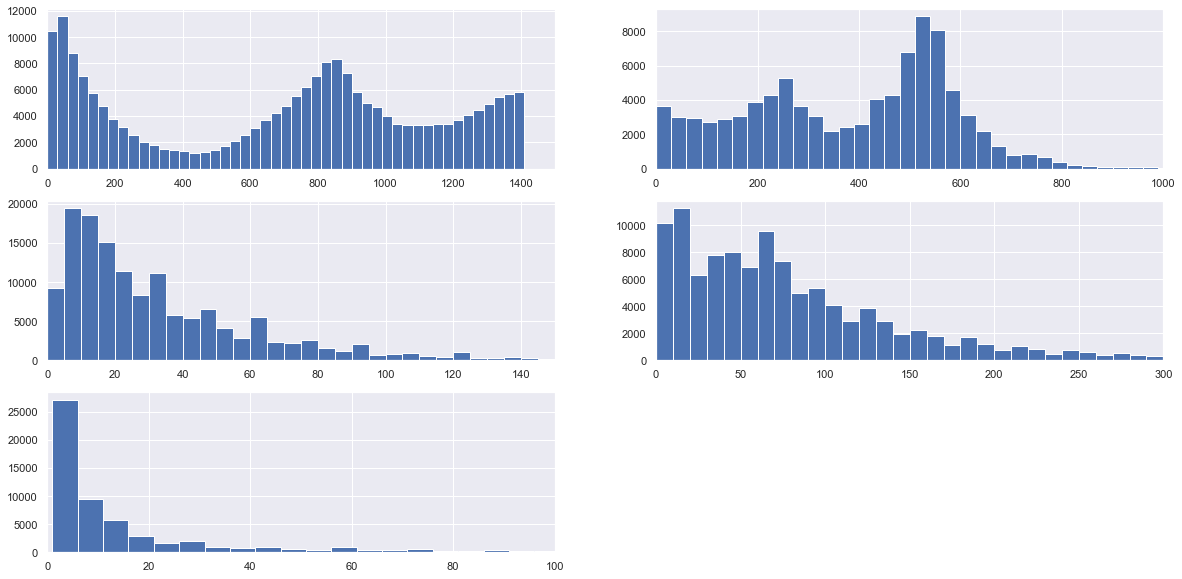

In [26]:
sns.set()
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(20,10))
ax1.hist(aufenthalt_zuhause, bins=range(int(min(aufenthalt_zuhause)), int(max(aufenthalt_zuhause)), 30));
ax1.set_xlim([0, 1500])
ax2.hist(aufenthalt_arbeit, bins=range(int(min(aufenthalt_arbeit)), int(max(aufenthalt_arbeit)), 30));
ax2.set_xlim([0,1000])
ax3.hist(aufenthalt_einkaufen, bins=range(int(min(aufenthalt_einkaufen)), int(max(aufenthalt_einkaufen)), 5));
ax3.set_xlim([0,150])
ax4.hist(aufenthalt_freizeit, bins=range(int(min(aufenthalt_freizeit)), int(max(aufenthalt_freizeit)), 10));
ax4.set_xlim([0,300])
ax5.hist(aufenthalt_sonstiges, bins=range(int(min(aufenthalt_sonstiges)), int(max(aufenthalt_sonstiges)), 5));
ax5.set_xlim([0,100])
fig.delaxes(ax6)


## Verteilungsfunktion über Density Estimation Modell

In [27]:
from sklearn.neighbors import KernelDensity

In [28]:
# Erstellen Kernel Density Estimation Modell Zuhause 
kde_model_zuhause = KernelDensity(bandwidth=13)
kde_model_zuhause.fit(aufenthalt_zuhause[:, np.newaxis])
# übertragen in visaulisierbare Wahrscheinlichkeitsdichtefunktion
x = np.linspace(0, max(aufenthalt_zuhause), 1000)
log_pdf = kde_model_zuhause.score_samples(x[:, np.newaxis])
kde_zuhause_pdf = np.exp(log_pdf)

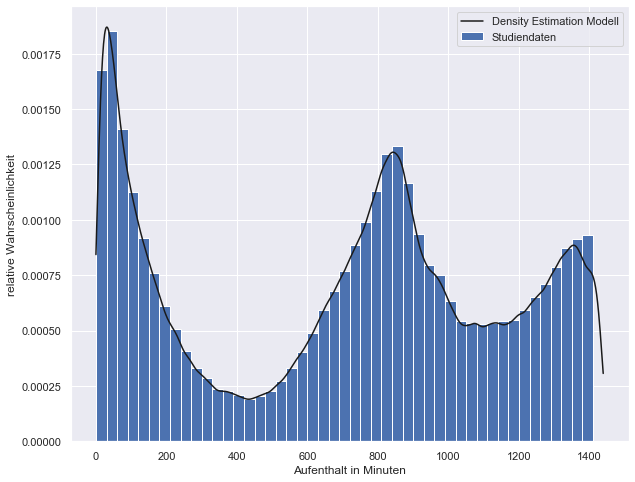

In [29]:
plt.figure(figsize=(10,8))
plt.hist(aufenthalt_zuhause, bins=range(int(min(aufenthalt_zuhause)), int(max(aufenthalt_zuhause)), 30), density=True);
plt.plot(x, kde_zuhause_pdf, '-k');
labels = ["Density Estimation Modell", "Studiendaten"]
plt.legend(labels);
plt.xlabel("Aufenthalt in Minuten");
plt.ylabel("relative Wahrscheinlichkeit");

In [30]:
# Erstellen Kernel Density Estimation Modell Arbeit 
kde_model_arbeit = KernelDensity(bandwidth=18)
kde_model_arbeit.fit(aufenthalt_arbeit[:, np.newaxis])
# übertragen in visaulisierbare Wahrscheinlichkeitsdichtefunktion
x = np.linspace(0, max(aufenthalt_arbeit), 1000)
log_pdf = kde_model_arbeit.score_samples(x[:, np.newaxis])
kde_arbeit_pdf = np.exp(log_pdf)

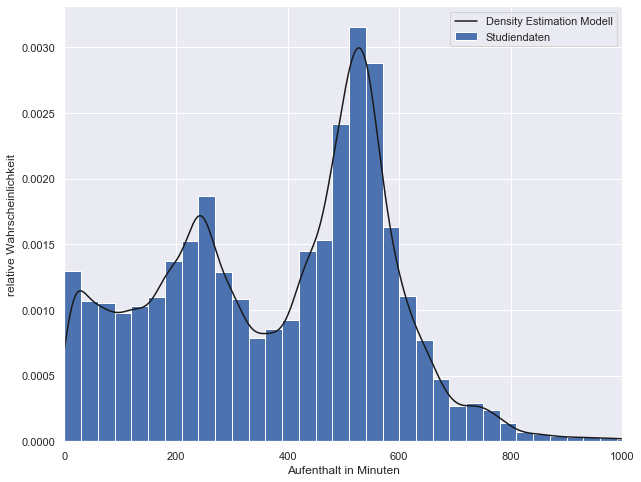

In [31]:
plt.figure(figsize=(10,8))
plt.hist(aufenthalt_arbeit, bins=range(int(min(aufenthalt_arbeit)), int(max(aufenthalt_arbeit)), 30), density=True);
plt.plot(x, kde_arbeit_pdf, '-k');
labels = ["Density Estimation Modell", "Studiendaten"]
plt.legend(labels);
plt.gca().set_xlim(0, 1000)
plt.xlabel("Aufenthalt in Minuten");
plt.ylabel("relative Wahrscheinlichkeit");

In [32]:
# Erstellen Kernel Density Estimation Modell Einkaufen 
kde_model_einkaufen = KernelDensity(bandwidth=8)
kde_model_einkaufen.fit(aufenthalt_einkaufen[:, np.newaxis])
# übertragen in visaulisierbare Wahrscheinlichkeitsdichtefunktion
x = np.linspace(0, max(aufenthalt_einkaufen), 1000)
log_pdf = kde_model_einkaufen.score_samples(x[:, np.newaxis])
kde_einkaufen_pdf = np.exp(log_pdf)

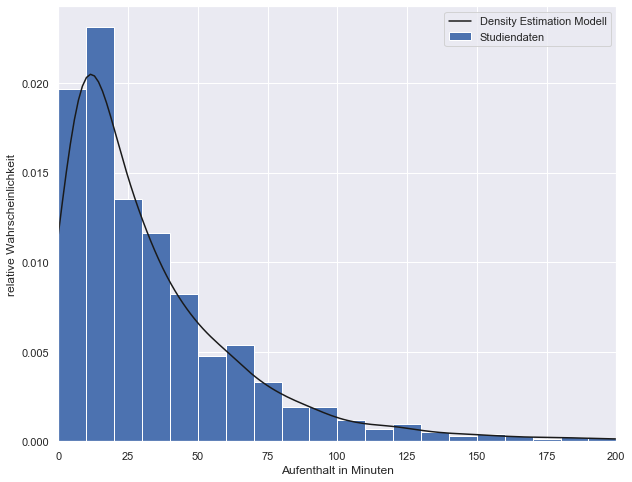

In [33]:
plt.figure(figsize=(10,8))
plt.hist(aufenthalt_einkaufen, bins=range(int(min(aufenthalt_einkaufen)), int(max(aufenthalt_einkaufen)), 10), density=True);
plt.plot(x, kde_einkaufen_pdf, '-k');
labels = ["Density Estimation Modell", "Studiendaten"]
plt.legend(labels);
plt.gca().set_xlim(0, 200)
plt.xlabel("Aufenthalt in Minuten");
plt.ylabel("relative Wahrscheinlichkeit");

In [43]:
# Erstellen Kernel Density Estimation Modell Freizeit
kde_model_freizeit = KernelDensity(bandwidth=8)
kde_model_freizeit.fit(aufenthalt_freizeit[:, np.newaxis])
# übertragen in visaulisierbare Wahrscheinlichkeitsdichtefunktion
x = np.linspace(0, max(aufenthalt_freizeit), 1000)
log_pdf = kde_model_freizeit.score_samples(x[:, np.newaxis])
kde_freizeit_pdf = np.exp(log_pdf)

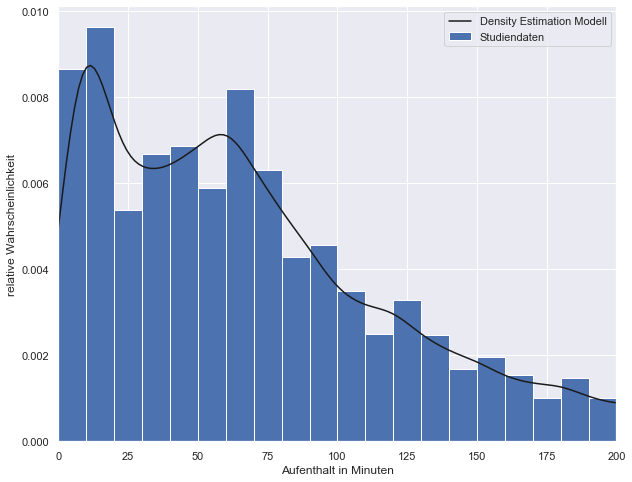

In [44]:
plt.figure(figsize=(10,8))
plt.hist(aufenthalt_freizeit, bins=range(int(min(aufenthalt_freizeit)), int(max(aufenthalt_freizeit)), 10), density=True);
plt.plot(x, kde_freizeit_pdf, '-k');
labels = ["Density Estimation Modell", "Studiendaten"]
plt.legend(labels);
plt.gca().set_xlim(0, 200)
plt.xlabel("Aufenthalt in Minuten");
plt.ylabel("relative Wahrscheinlichkeit");

In [41]:
# Erstellen Kernel Density Estimation Modell Sonstiges
kde_model_sonstiges = KernelDensity(bandwidth=4)
kde_model_sonstiges.fit(aufenthalt_sonstiges[:, np.newaxis])
# übertragen in visaulisierbare Wahrscheinlichkeitsdichtefunktion
x = np.linspace(0, max(aufenthalt_sonstiges), 1000)
log_pdf = kde_model_sonstiges.score_samples(x[:, np.newaxis])
kde_sonstiges_pdf = np.exp(log_pdf)

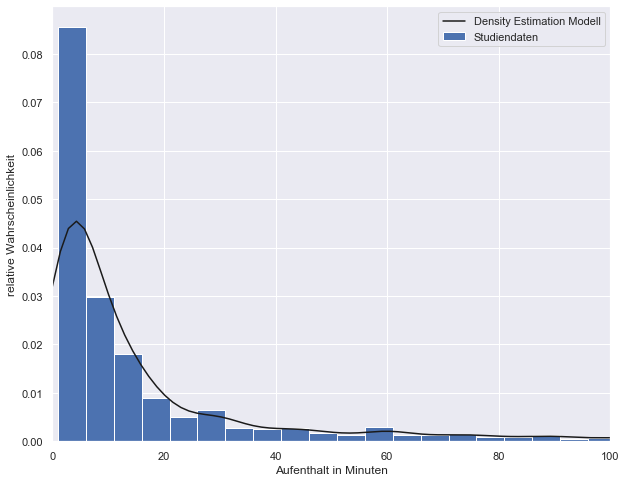

In [42]:
plt.figure(figsize=(10,8))
plt.hist(aufenthalt_sonstiges, bins=range(int(min(aufenthalt_sonstiges)), int(max(aufenthalt_sonstiges)), 5), density=True);
plt.plot(x, kde_sonstiges_pdf, '-k');
labels = ["Density Estimation Modell", "Studiendaten"]
plt.legend(labels);
plt.gca().set_xlim(0, 100)
plt.xlabel("Aufenthalt in Minuten");
plt.ylabel("relative Wahrscheinlichkeit");

## Modelle speichern

In [38]:
from pathlib import Path
import pickle
import os

root = os.getcwd()
if not os.path.exists(os.getcwd()+ "\\Simulationsdaten"):
    os.makedirs(root+"\\Simulationsdaten")

# Modelle in Liste zusammenfassen
models = [kde_model_zuhause, kde_model_arbeit, kde_model_einkaufen, kde_model_freizeit, kde_model_sonstiges]
    
path = root+"\\Simulationsdaten"+"\\Modelle_Aufenthaltsdauer_Werktag.pickle"
pickle.dump(models, open(path, "wb"))
